In [1]:
import sys
import os
import numpy as np
import cv2
import scipy.sparse as sp
import torch
from matplotlib import pyplot as plt

HybridGNet_pth = os.path.abspath('../CheXmask-Database-main/HybridGNet')
if HybridGNet_pth not in sys.path: sys.path.append(HybridGNet_pth)

from models.HybridGNet2IGSC import Hybrid
from utils.utils import scipy_to_torch_sparse, genMatrixesLungsHeart

In [2]:
# def getDenseMask(RL, LL, H):
#     img = np.zeros([1024,1024], dtype = 'uint8')
    
#     RL = RL.reshape(-1, 1, 2).astype('int')
#     LL = LL.reshape(-1, 1, 2).astype('int')
#     H = H.reshape(-1, 1, 2).astype('int')

#     img = cv2.drawContours(img, [RL], -1, 1, -1)
#     img = cv2.drawContours(img, [LL], -1, 1, -1)
#     img = cv2.drawContours(img, [H], -1, 2, -1)
    
#     return img


def DrawMask(gsImg, RL, LL, H):

    gsImg = (gsImg * 255).astype(np.uint8)

    img = cv2.cvtColor(gsImg, cv2.COLOR_GRAY2RGB)
    
    RL = RL.reshape(-1, 1, 2).astype('int')
    LL = LL.reshape(-1, 1, 2).astype('int')
    H = H.reshape(-1, 1, 2).astype('int')

    img = cv2.drawContours(img, [RL], -1, (255, 0, 0), 3)
    img = cv2.drawContours(img, [LL], -1, (0, 255, 0), 3)
    img = cv2.drawContours(img, [H], -1, (0, 0, 255), 3)
    
    return img

In [3]:
device = "cpu"


A, AD, D, U = genMatrixesLungsHeart()
N1 = A.shape[0]
N2 = AD.shape[0]

A = sp.csc_matrix(A).tocoo()
AD = sp.csc_matrix(AD).tocoo()
D = sp.csc_matrix(D).tocoo()
U = sp.csc_matrix(U).tocoo()

D_ = [D.copy()]
U_ = [U.copy()]

config = {}

config['n_nodes'] = [N1, N1, N1, N2, N2, N2]
A_ = [A.copy(), A.copy(), A.copy(), AD.copy(), AD.copy(), AD.copy()]
A_t, D_t, U_t = ([scipy_to_torch_sparse(x).to(device) for x in X] for X in (A_, D_, U_))

config['latents'] = 64
config['inputsize'] = 1024

f = 32
config['filters'] = [2, f, f, f, f//2, f//2, f//2]
config['skip_features'] = f


hybrid = Hybrid(config.copy(), D_t, U_t, A_t).to(device)
hybrid.load_state_dict(torch.load(os.path.join(HybridGNet_pth, "../Weights/SegmentationModel/bestMSE.pt"), 
                                  map_location=torch.device('cpu')))
hybrid.eval()
print('Model loaded')


Model loaded


/Users/sogand/Desktop/segmentation-2025/CheXmask-Database-main/HybridGNet/utils/utils.py:56: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /private/var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_35qhz7nt_q/croot/libtorch_1738269285820/work/torch/csrc/utils/tensor_new.cpp:653.)
  sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))
/var/folders/ny/r0bq7b513_qd07rknvttg91r0000gn/T/ipykernel_17955/2815268437.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped

/Users/sogand/miniconda3/envs/env4/lib/python3.12/site-packages/torch/nn/modules/instancenorm.py:115: UserWarning: input's size at dim=1 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(


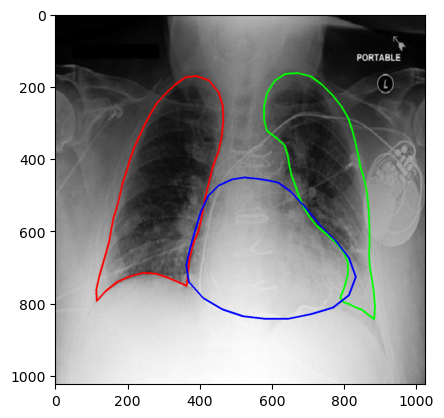

In [5]:
img = cv2.imread('../data/mimic-cxr-mini/test/s50010747.jpg', 0) / 255.0
img = cv2.resize(img, (1024, 1024))
# plt.imshow(img, cmap='gray')

data = torch.from_numpy(img).unsqueeze(0).unsqueeze(0).to(device).float()
# print(torch.min(data))
# print(torch.max(data))
# print(data.shape)

with torch.no_grad():
    output = hybrid(data)
    if len(output) > 1:
        output = output[0]
    output = output.cpu().numpy().reshape(-1, 2) * 1024
    output = output.round().astype('int')

    RL = output[:44] 
    LL = output[44:94] 
    H = output[94:]
    
    # outseg = getDenseMask(RL, LL, H)
    plt.imshow(DrawMask(img, RL, LL, H))